# Preface
This notebook uses several packages from CRAN, as well as [Bioconductor](https://bioconductor.org). For a full list of attached packages see the session info in the Appendix at the end of this notebook. Several options have been adjusted to improve appearance of plots.

In [2]:
## Load necessary packages
suppressMessages({
    
    library("xcms")
    library("CAMERA")
    library("RColorBrewer")
    library("SummarizedExperiment")
    library("tidyverse")
    library("gplots")
    library("ggrepel")
    library("Rtsne")
    library("caret")
    library("MASS")
    
})

## Set session-specific options
options(repr.plot.width = 12, # Adjust plot width for publication purposes
        repr.plot.height = 8, # Adjust plot height for publication purposes,
        scipen = -1) # Adjust scientific notation of numbers to improve readability of plots

## List mzXML files
mzXMLs <- list.files(path = getwd(), recursive = TRUE, 
                     full.names = TRUE, pattern = ".mzXML")

# Quality Control of Raw Data
The following injection order during analysis correspond to the order files are read using list.files. In case several batches were analysed, as vector containing an integer for each batch assignment of each sample must be given.

In [3]:
## List mzXML files
mzXMLs <- list.files(path = "Gold_pos", recursive = TRUE, 
                     full.names = TRUE, pattern = ".mzXML")

## Aggregate meta data
sample.name <- sub(basename(mzXMLs), pattern = ".mzXML", 
                   replacement = "", fixed = TRUE)
sample.group <- c(rep("Control", 5), rep("alpha-PCYP", 5), 
                  rep("QC", 7))
sample.order <- c(8,10,15,7,13,16,12,9,14,6,1,2,3,4,5,11,17)
sample.batch <- NA
meta <- data.frame(sample_name = sample.name, 
                   sample_group = sample.group, 
                   sample_order = sample.order, 
                   sample_batch = sample.batch, 
                   stringsAsFactors = FALSE)

## Read raw data from disk
raw <- readMSData(files = mzXMLs[order(sample.order)], 
                  pdata = new("AnnotatedDataFrame", 
                              meta[order(sample.order),]), 
                  mode = "onDisk")
## Remove column equilibration and washing phases
raw <- filterRt(raw, c(60,600))

class(raw)

print(raw)

[1] "OnDiskMSnExp"
attr(,"package")
[1] "MSnbase"

MSn experiment data ("OnDiskMSnExp")
Object size in memory: 4.99 Mb
- - - Spectra data - - -
 MS level(s): 1 
 Number of spectra: 17694 
 MSn retention times: 1:0 - 9:60 minutes
- - - Processing information - - -
Data loaded [Fri Oct 22 13:32:25 2021] 
Filter: select retention time [60-600] and MS level(s), 1 [Fri Oct 22 13:32:25 2021] 
 MSnbase version: 2.14.2 
- - - Meta data  - - -
phenoData
  rowNames: 11 12 ... 17 (17 total)
  varLabels: sample_name sample_group sample_order sample_batch
  varMetadata: labelDescription
Loaded from:
  [1] pQC_1.mzXML...  [17] pQC_7.mzXML
  Use 'fileNames(.)' to see all files.
protocolData: none
featureData
  featureNames: F01.S0117 F01.S0118 ... F17.S1157 (17694 total)
  fvarLabels: fileIdx spIdx ... spectrum (35 total)
  fvarMetadata: labelDescription
experimentData: use 'experimentData(object)'


# Inspection of Parent Compound and Internal Standard
This experiment used deuterated tryptophan as an internal standard to normalise variability introduced by injection of the samples into the mass spectrometer. Quality control in at this stage includes ensuring that both the internal standard, as well as the parent compound, have been detected properly and the within group variability is acceptable.

In [4]:
## Define colours for experimental groups
group.colours <- paste0(brewer.pal(3, "Set1")[1:3])
names(group.colours) <- c("Control", "alpha-PCYP", "QC")

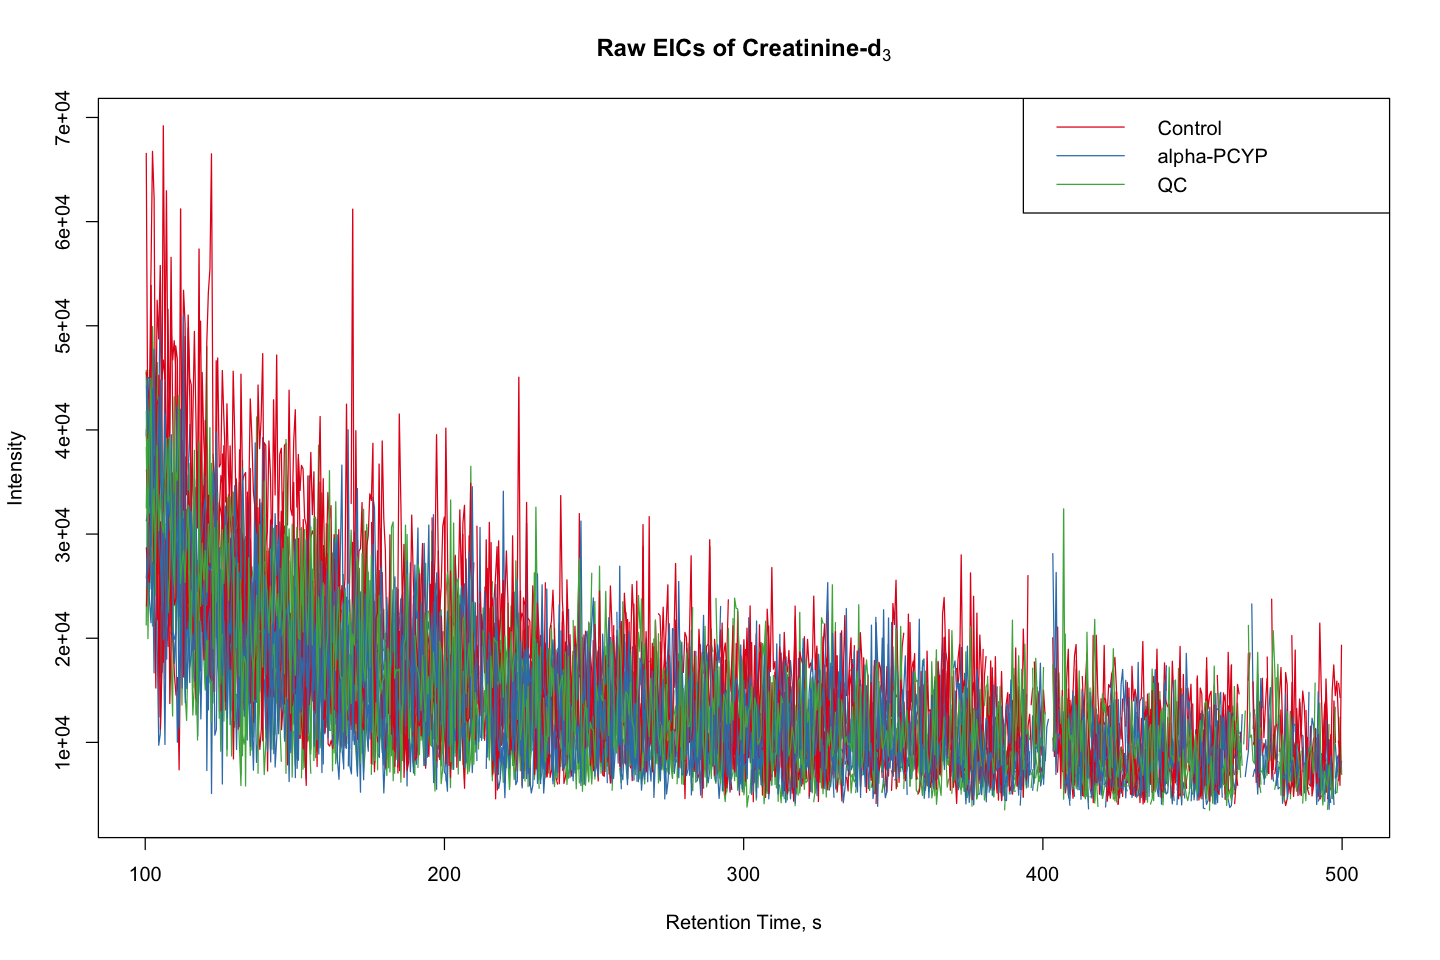

In [5]:
## Plot raw EICs of creatinine-d3 (m/z 117.0856, 25 s)
cread3.raw <- chromatogram(raw, mz = c(117.0841, 117.0871), rt = c(100, 500))

plot(cread3.raw, col = group.colours[cread3.raw$sample_group], 
     main = bquote(bold("Raw EICs of Creatinine-d"[3])), xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

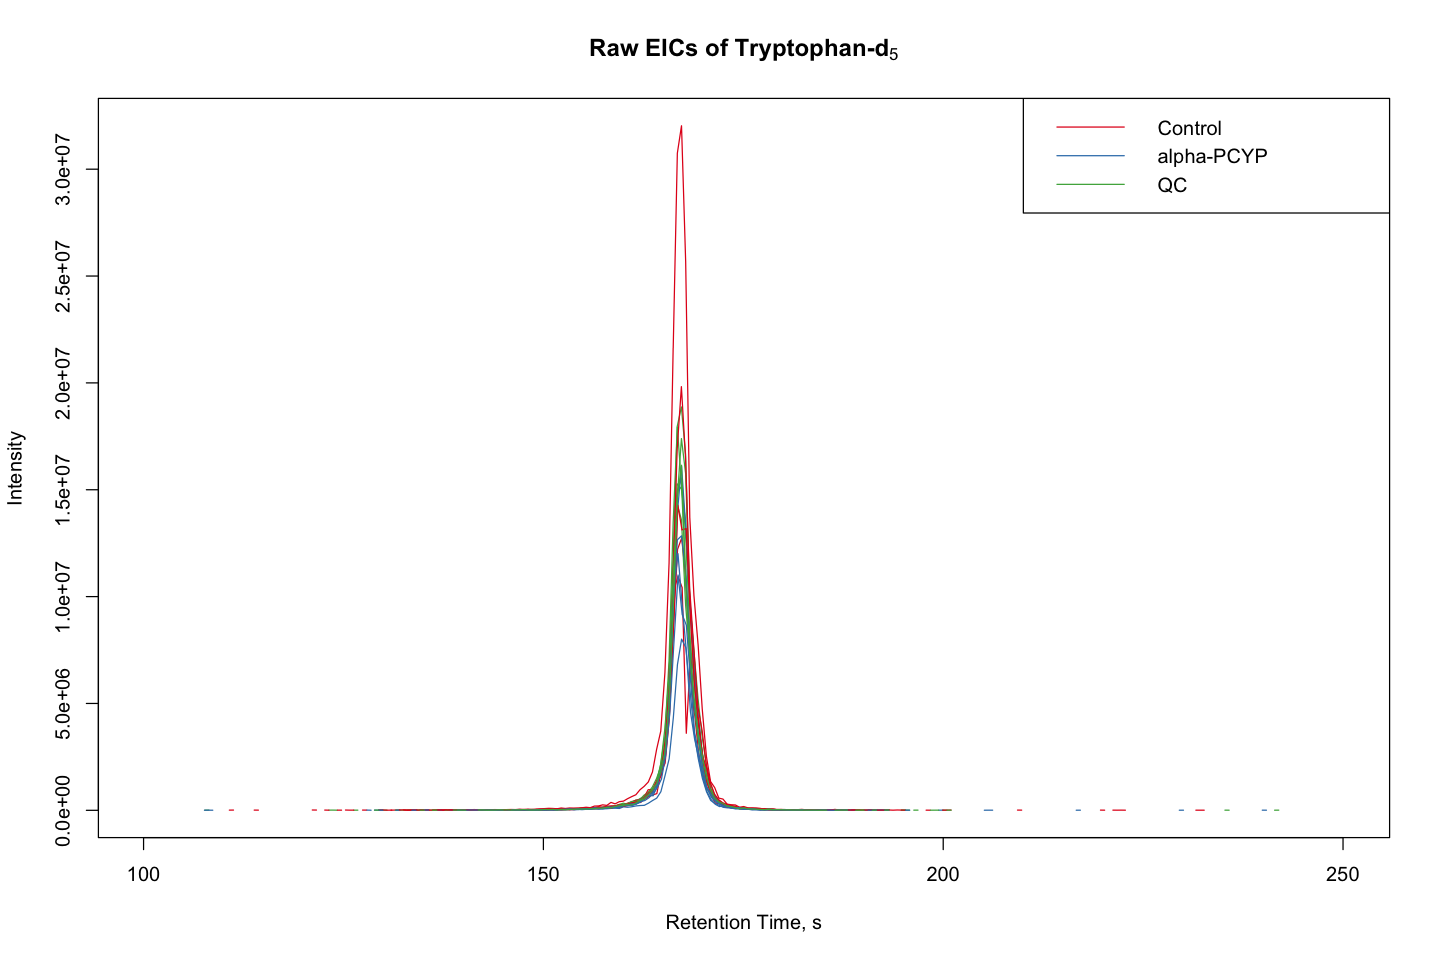

In [6]:
## Define colours for experimental groups
group.colours <- paste0(brewer.pal(3, "Set1")[1:3])
names(group.colours) <- c("Control", "alpha-PCYP", "QC")


## Plot tryptophan-d5 before processing (m/z 210.1291, 168 s)
trpd5.raw <- chromatogram(raw, mz = c(210.1281, 210.1296), rt = c(100, 250))

plot(trpd5.raw, col = group.colours[trpd5.raw$sample_group], 
     main = bquote(bold("Raw EICs of Tryptophan-d"[5])), xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

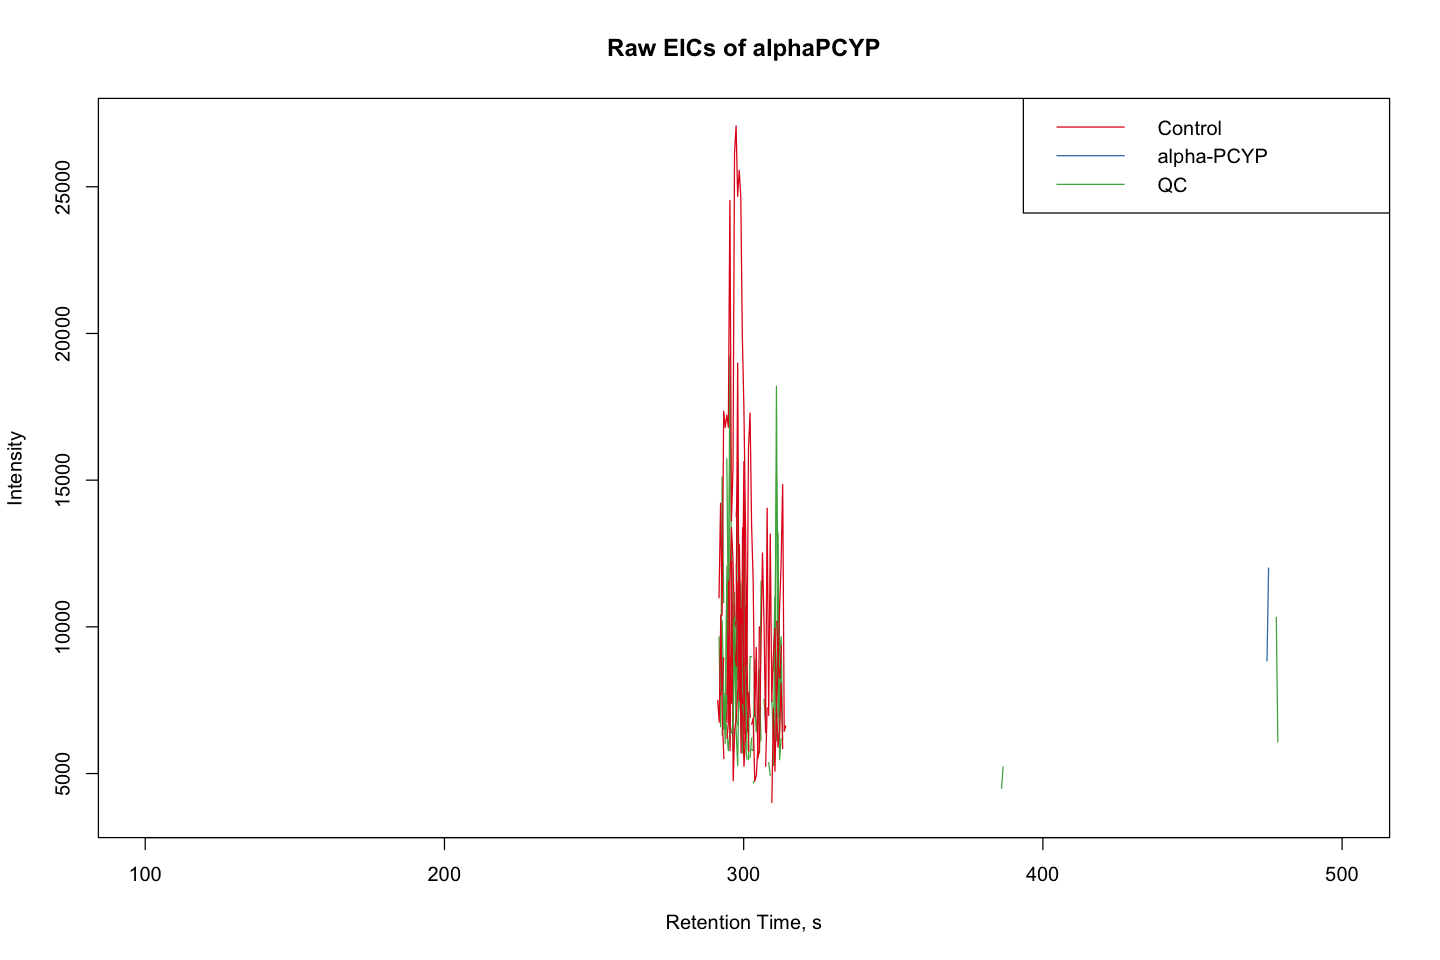

In [7]:
## Plot raw EICs of alpha-PCYP (m/z 272.2008, 25 s)
alphaPCYP.raw <- chromatogram(raw, mz = c(272.2000, 272.2015), rt = c(100, 500))

plot(alphaPCYP.raw, col = group.colours[alphaPCYP.raw$sample_group], 
     main = bquote(bold("Raw EICs of alphaPCYP")), xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

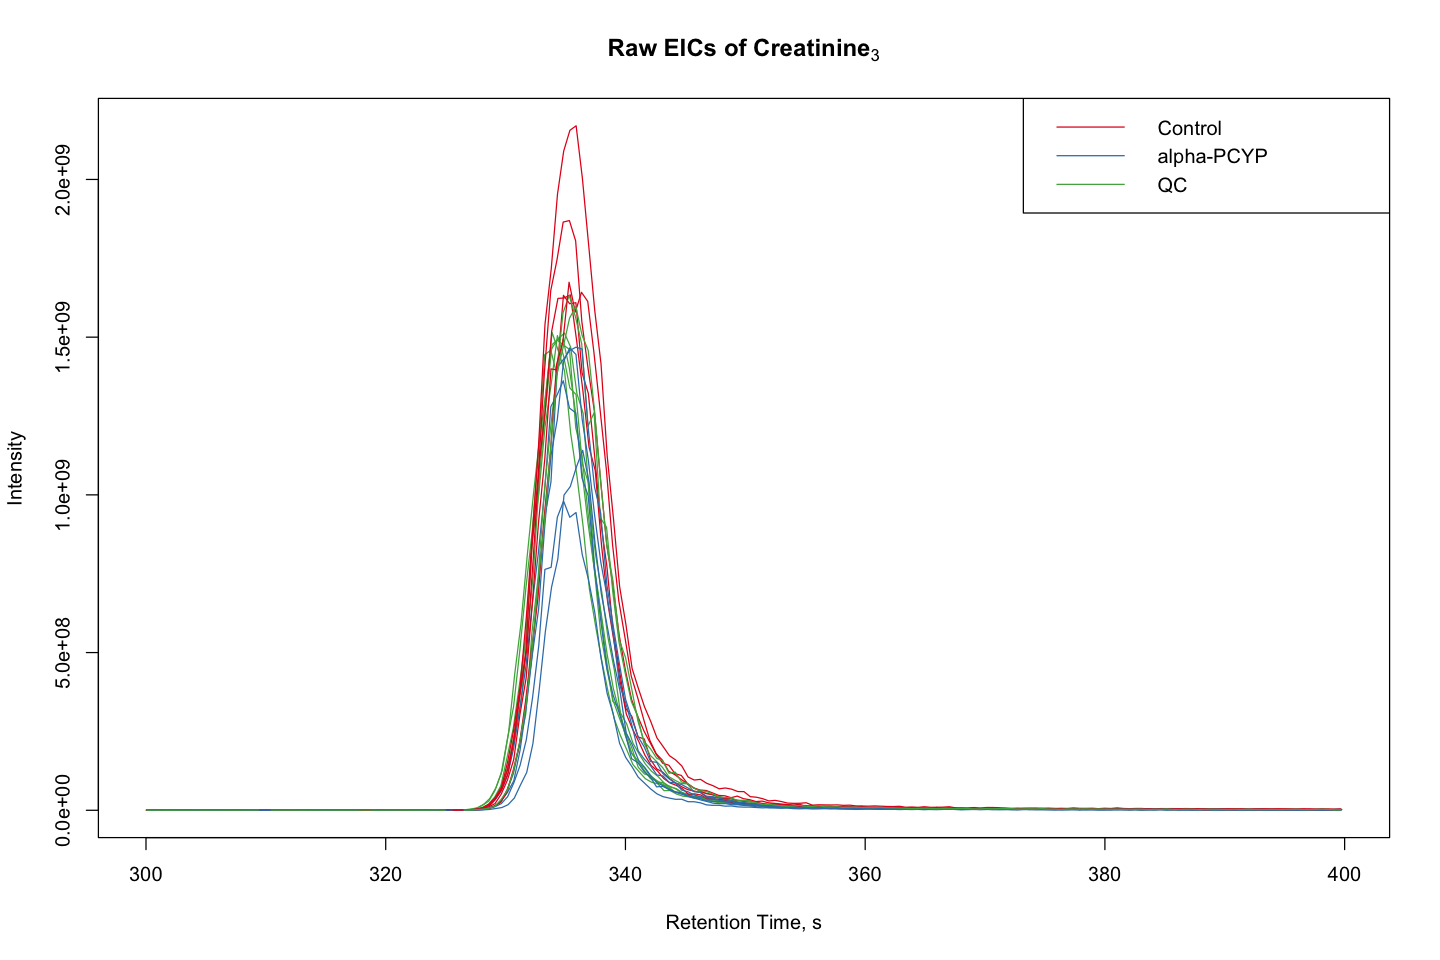

In [12]:
## Plot raw EICs of creatinine (m/z 114.0665, 25 s)
crea.raw <- chromatogram(raw, mz = c(114.0645, 114.0685), rt = c(300, 400))

plot(crea.raw, col = group.colours[crea.raw$sample_group], 
     main = bquote(bold("Raw EICs of Creatinine"[3])), xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

# Inspect Total Ion Currents of Sample Files

Total ion currents (TICs) need to be inspected in order to ensure that chromatography and mass spectrometry have been performing properly. Quality control includes the inspection of retention time drifts within TICS and evaluation of the baselines.

In [8]:
## Get total ion chromatograms
tics <- chromatogram(raw, aggregationFun = "sum")

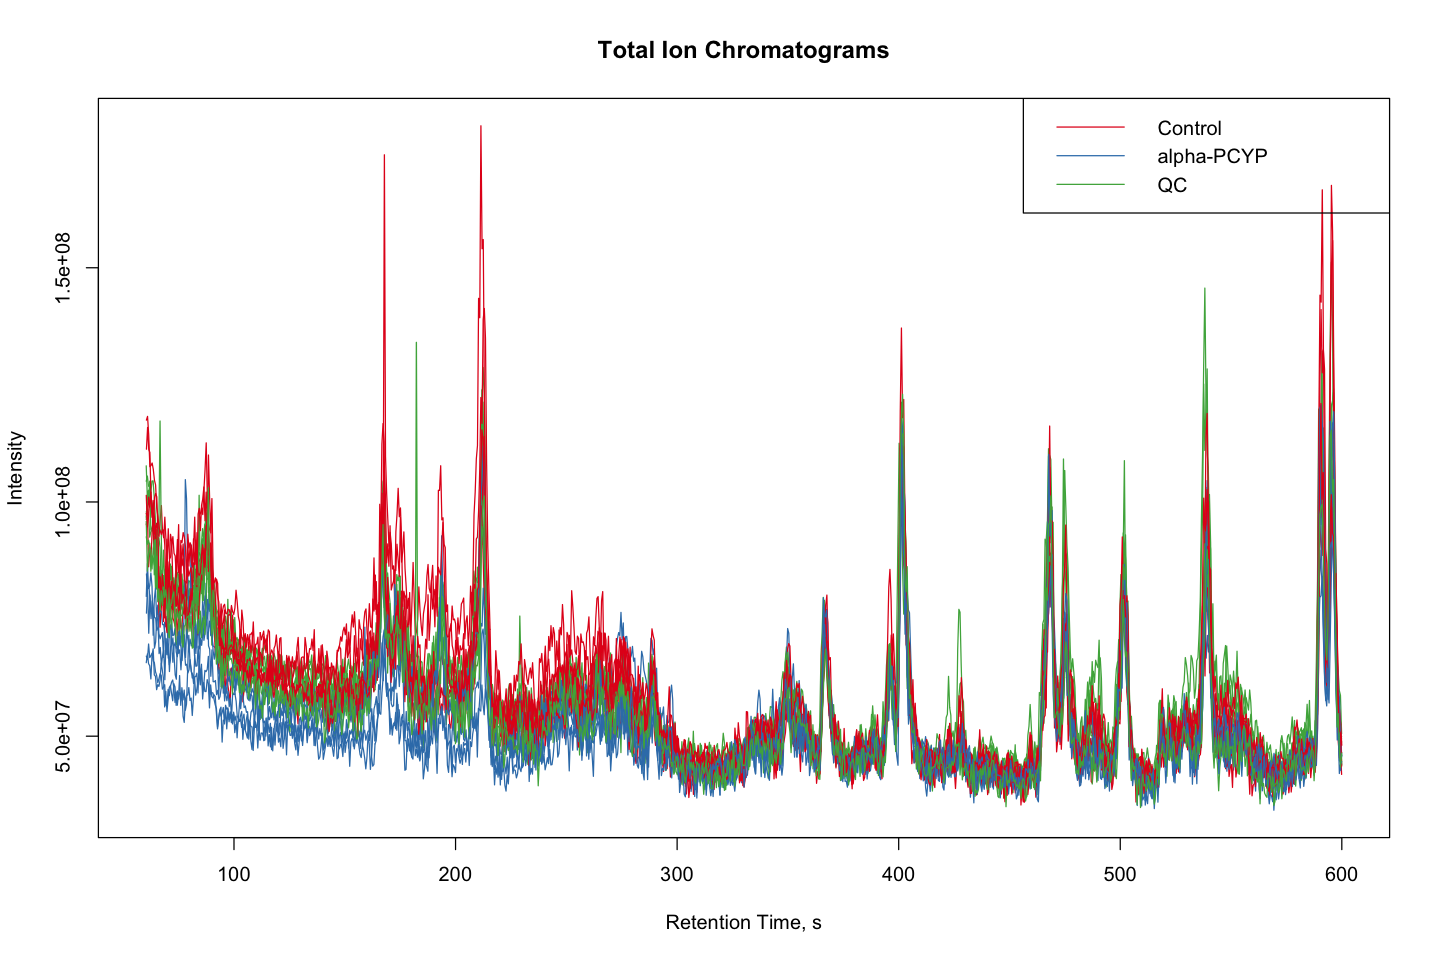

In [9]:
## Plot every total ion chromatogram of the data set
plot(tics, col = group.colours[raw$sample_group], 
     main = "Total Ion Chromatograms", ylab = "Intensity", 
     xlab = "Retention Time, s")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

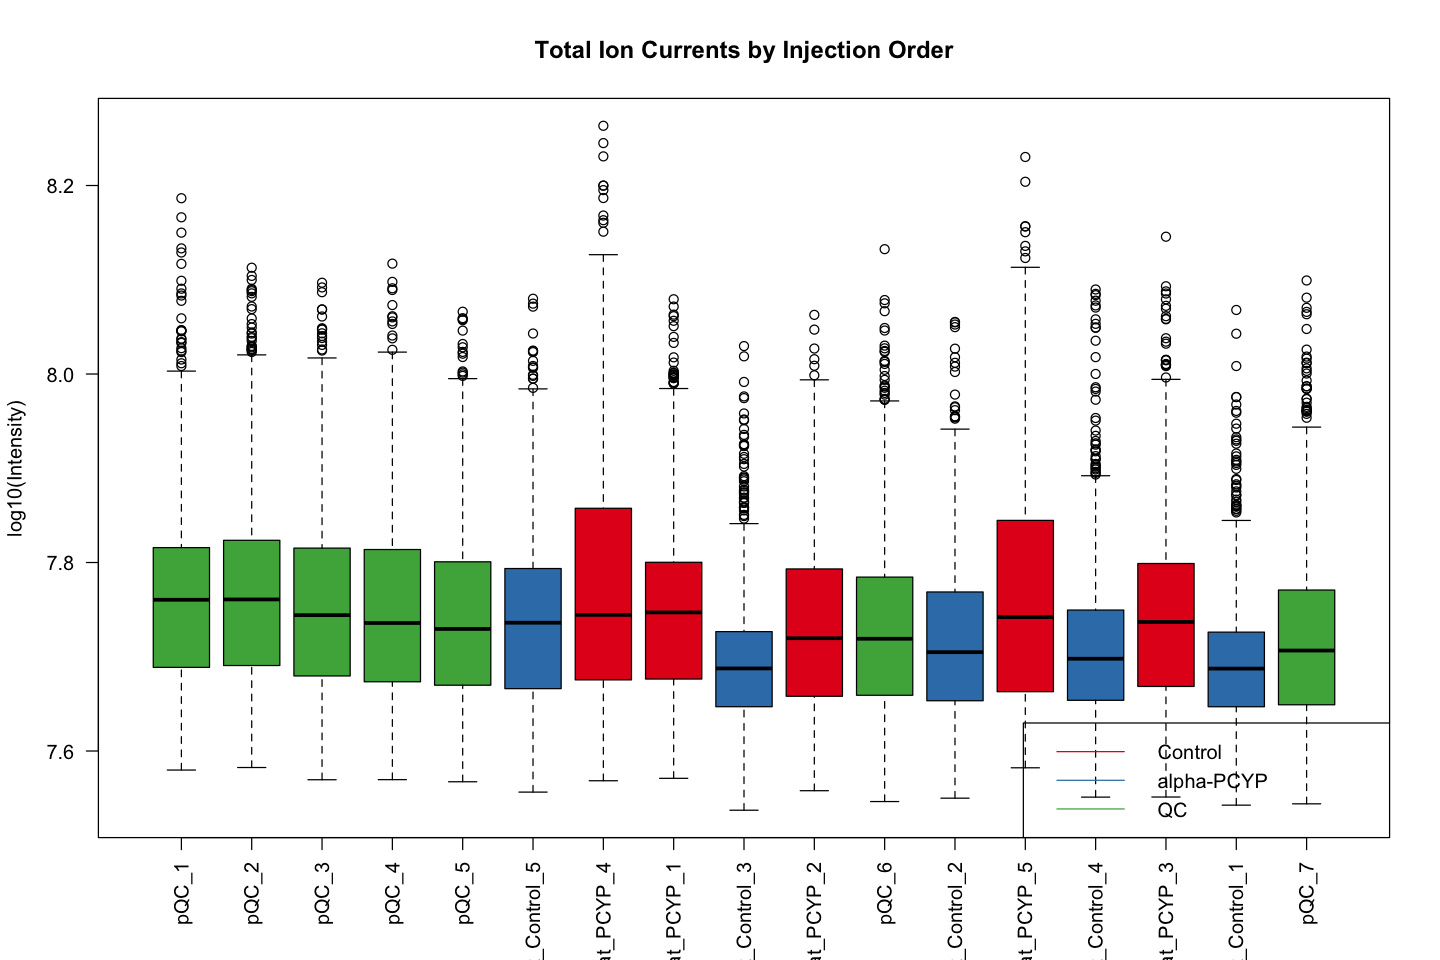

In [10]:
# Inspect boxplots of TICs by injection order
tics.summary <- split(tic(raw), f = fromFile(raw))

boxplot(sapply(tics.summary, log10), names = raw$sample_name, 
        col = group.colours[raw$sample_group], ylab = "log10(Intensity)", 
        main = "Total Ion Currents by Injection Order", las = 2)
legend("bottomright", legend = names(group.colours), 
       col = group.colours, lty = 1)

# Preprocessing of Raw Sample Files

# Peak Picking

Parameter used in this section were obtained using the one-by-one optimization performed by centWaveOpt. This approach was published at DOI: 10.1002/dta.2552 by Manier et al.

In [11]:
cwp <- CentWaveParam(peakwidth = c(8.9, 17), ppm = 2.5, snthresh = 12, 
                     mzdiff = 0.004,  prefilter = c(5, 100))

suppressMessages(
    
    set <- findChromPeaks(raw, param = cwp)
    
    )

In [12]:
## Define sample colours
sample.colours <- paste0(brewer.pal(3, "Set1")[1:3], "60")
names(sample.colours) <- c("Control", "alpha-PCYP", "QC")
sample.colours <- sample.colours[raw$sample_group]

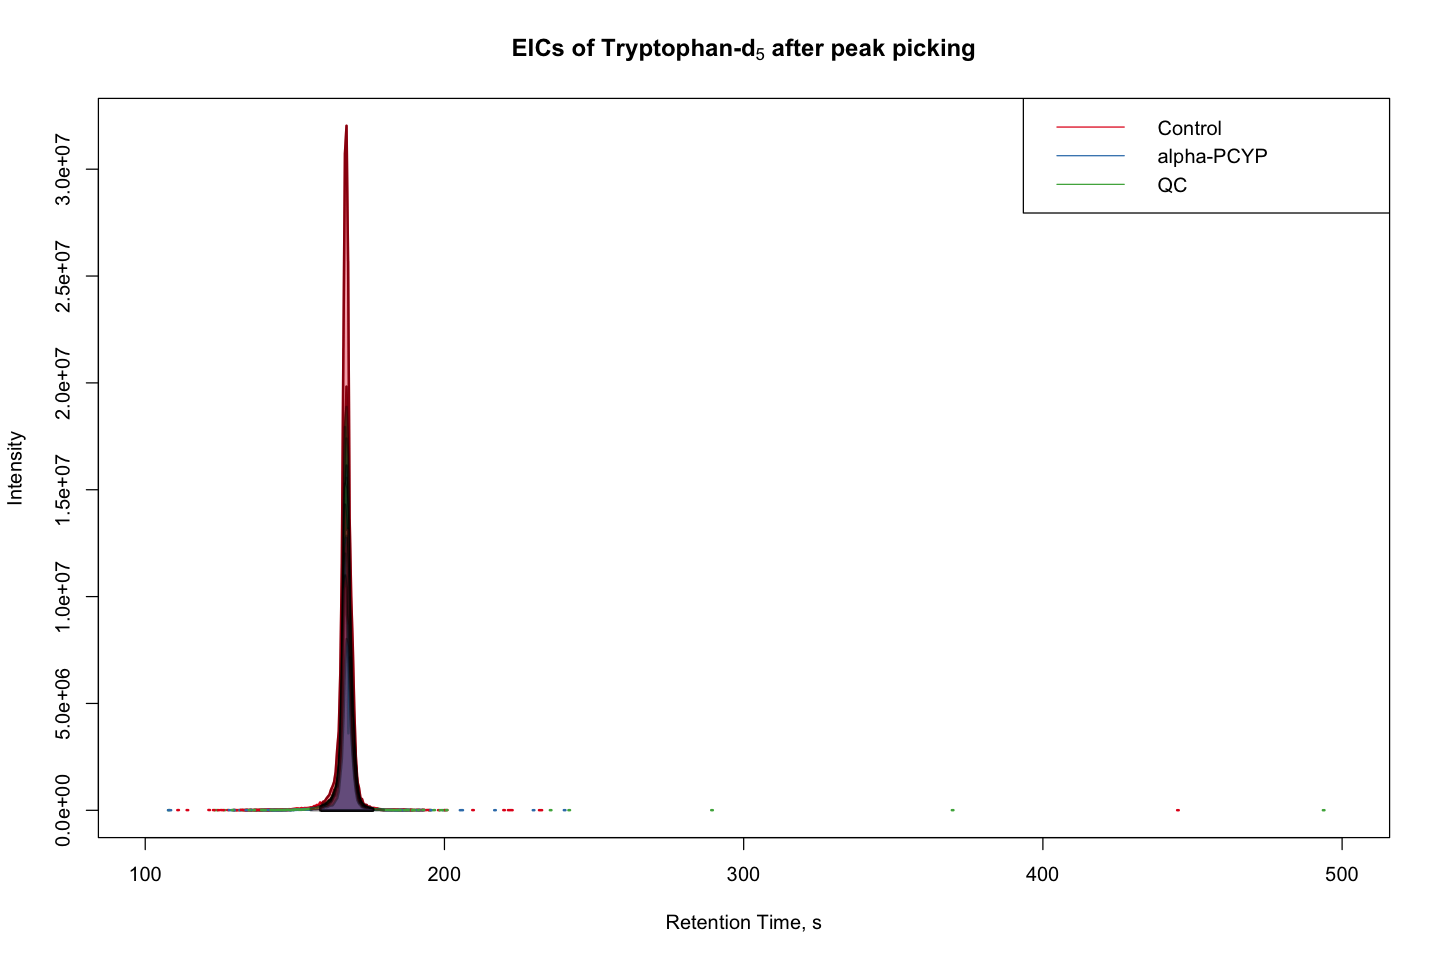

In [13]:
## Plot Tryptophan-d5 after peak picking (m/z 210.1291, 168 s)
trpd5.picked <- chromatogram(set, mz = c(210.1281, 210.1301), rt = c(100, 500)) 

plot(trpd5.picked, col = group.colours[trpd5.raw$sample_group], lwd = 2,
     peakBg = sample.colours[chromPeaks(trpd5.picked)[, "sample"]],
     main = bquote(bold("EICs of Tryptophan-d"[5]*" after peak picking")), xlab = "Retention Time, s",
     ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

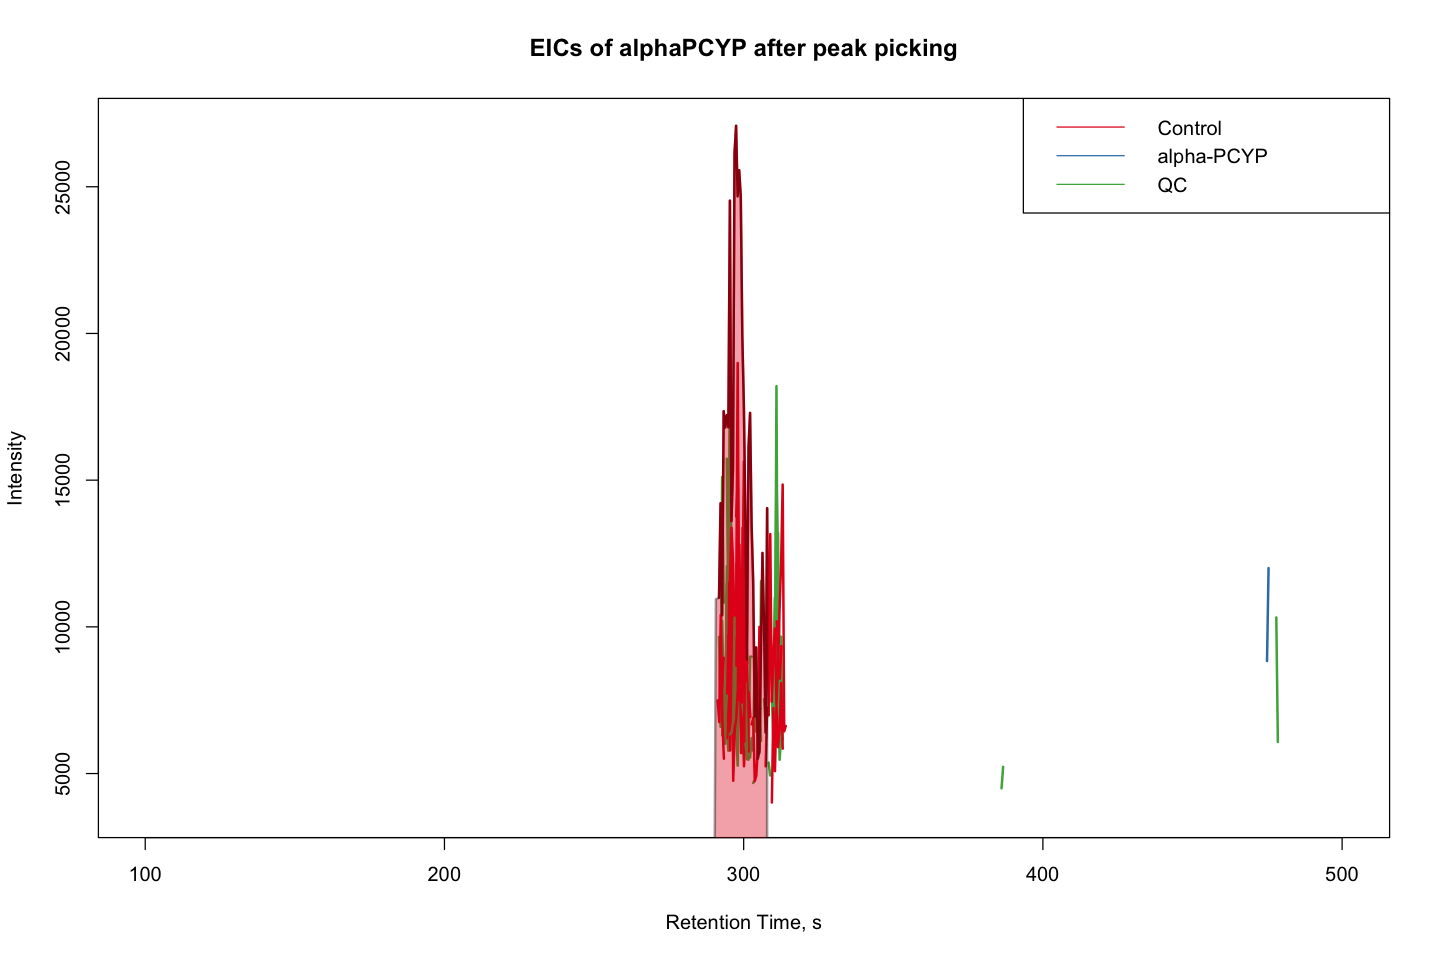

In [15]:
## Plot alpha-PCYP after peak picking (m/z 272.2008, 314 s)
alphaPCYP.picked <- chromatogram(set, mz = c(272.2000, 272.2015), rt = c(100, 500)) 

plot(alphaPCYP.picked, col = group.colours[alphaPCYP.raw$sample_group], lwd = 2,
     peakBg = sample.colours[chromPeaks(alphaPCYP.picked)[, "sample"]],
     main = bquote(bold("EICs of alphaPCYP"*" after peak picking")), xlab = "Retention Time, s",
     ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

# Retention Time Correction

In [16]:
suppressMessages({
    
    set <- adjustRtime(set, param = ObiwarpParam(binSize = 0.6))
    set <- dropAdjustedRtime(set)

    pdp <- PeakDensityParam(sampleGroups = set$sample_group, bw = 1)
    set <- groupChromPeaks(set, param = pdp)

    ## Define subset alignment options and perform the alignment
    pgp <- PeakGroupsParam(minFraction = 0.8, 
                           subset = which(set$sample_group == "QC"),
                           subsetAdjust = "average", span = 0.2)
    set <- adjustRtime(set, param = pgp)
    
})

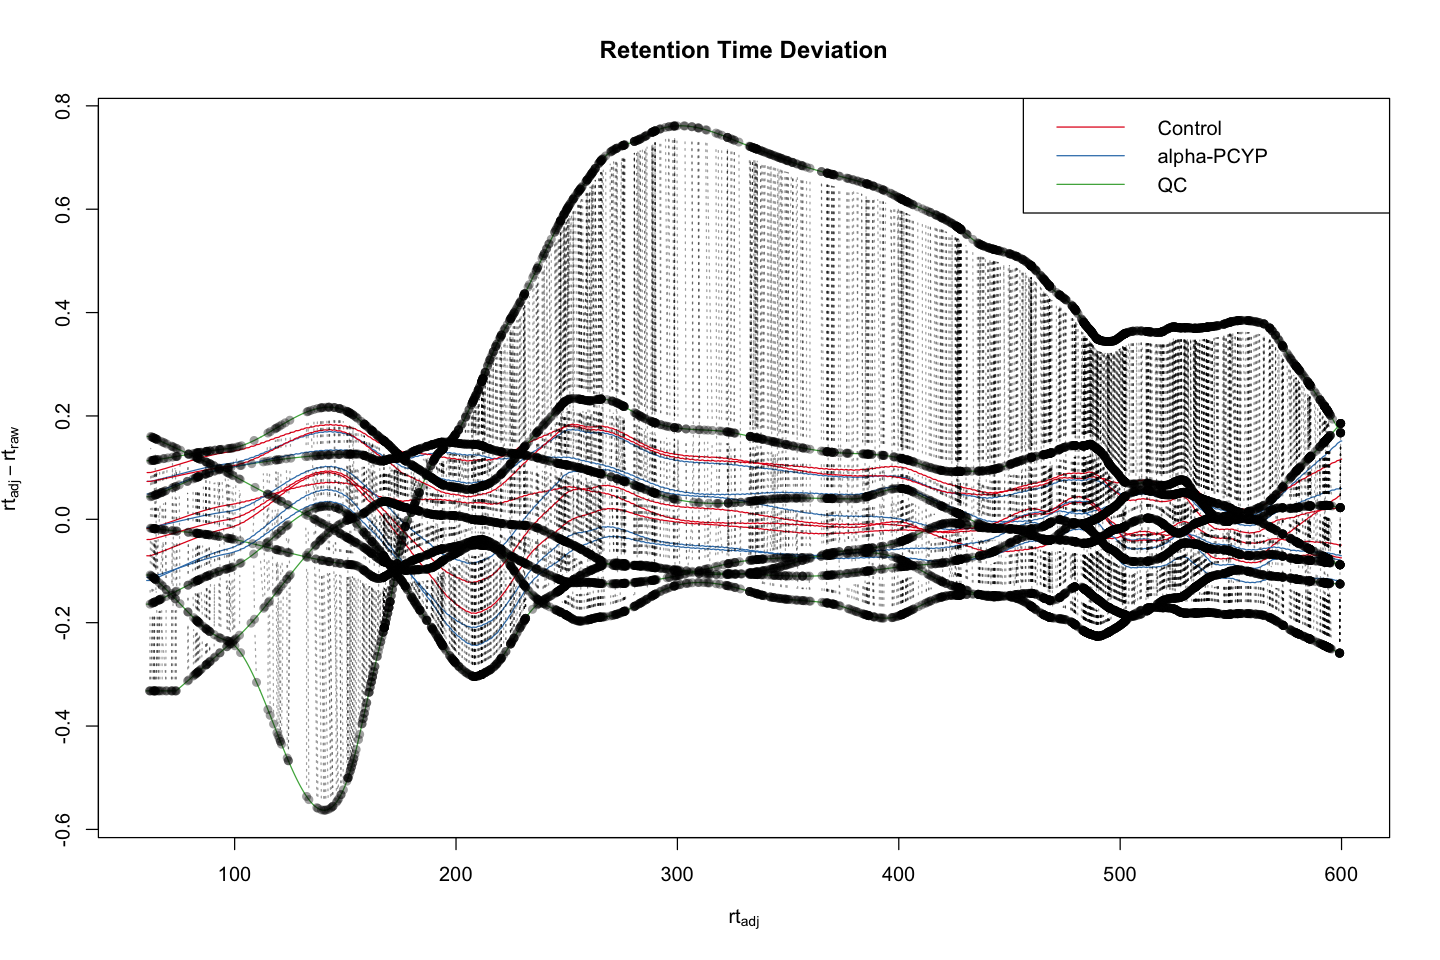

In [17]:
## Plot difference of adjusted to raw retention time.
plotAdjustedRtime(set, col = group.colours[set$sample_group], 
                  main = "Retention Time Deviation")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

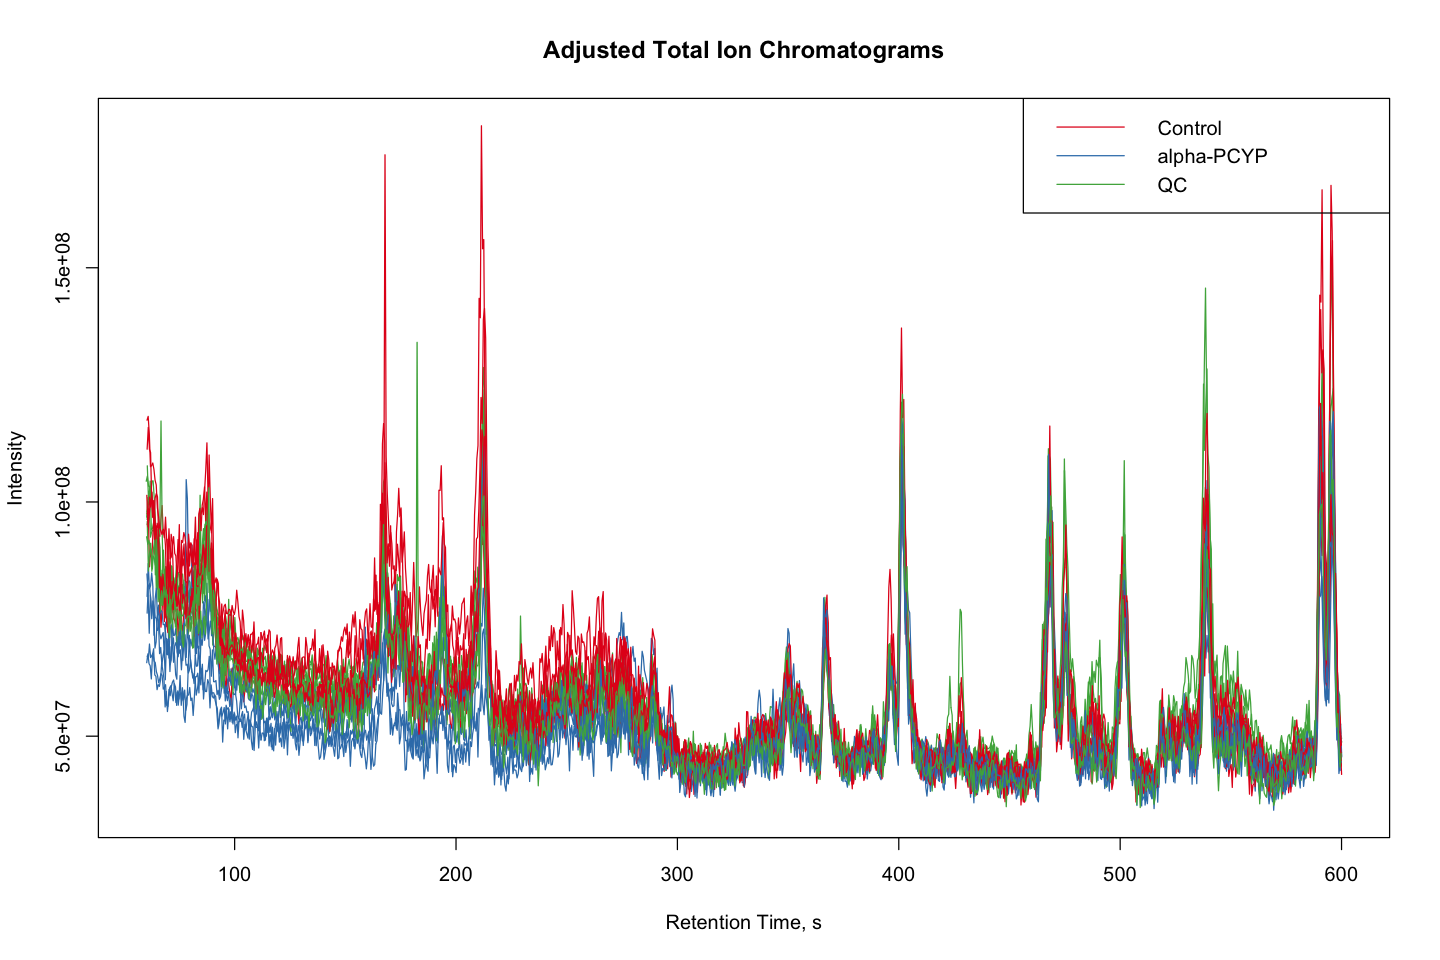

In [18]:
## Get the retention time-adjusted total ion chromatograms.
tics.corr <- chromatogram(set, aggregationFun = "sum")

plot(tics.corr, col = group.colours[tics.corr$sample_group], 
     peakType = "none", main = "Adjusted Total Ion Chromatograms", 
     xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), col = group.colours, lty = 1)

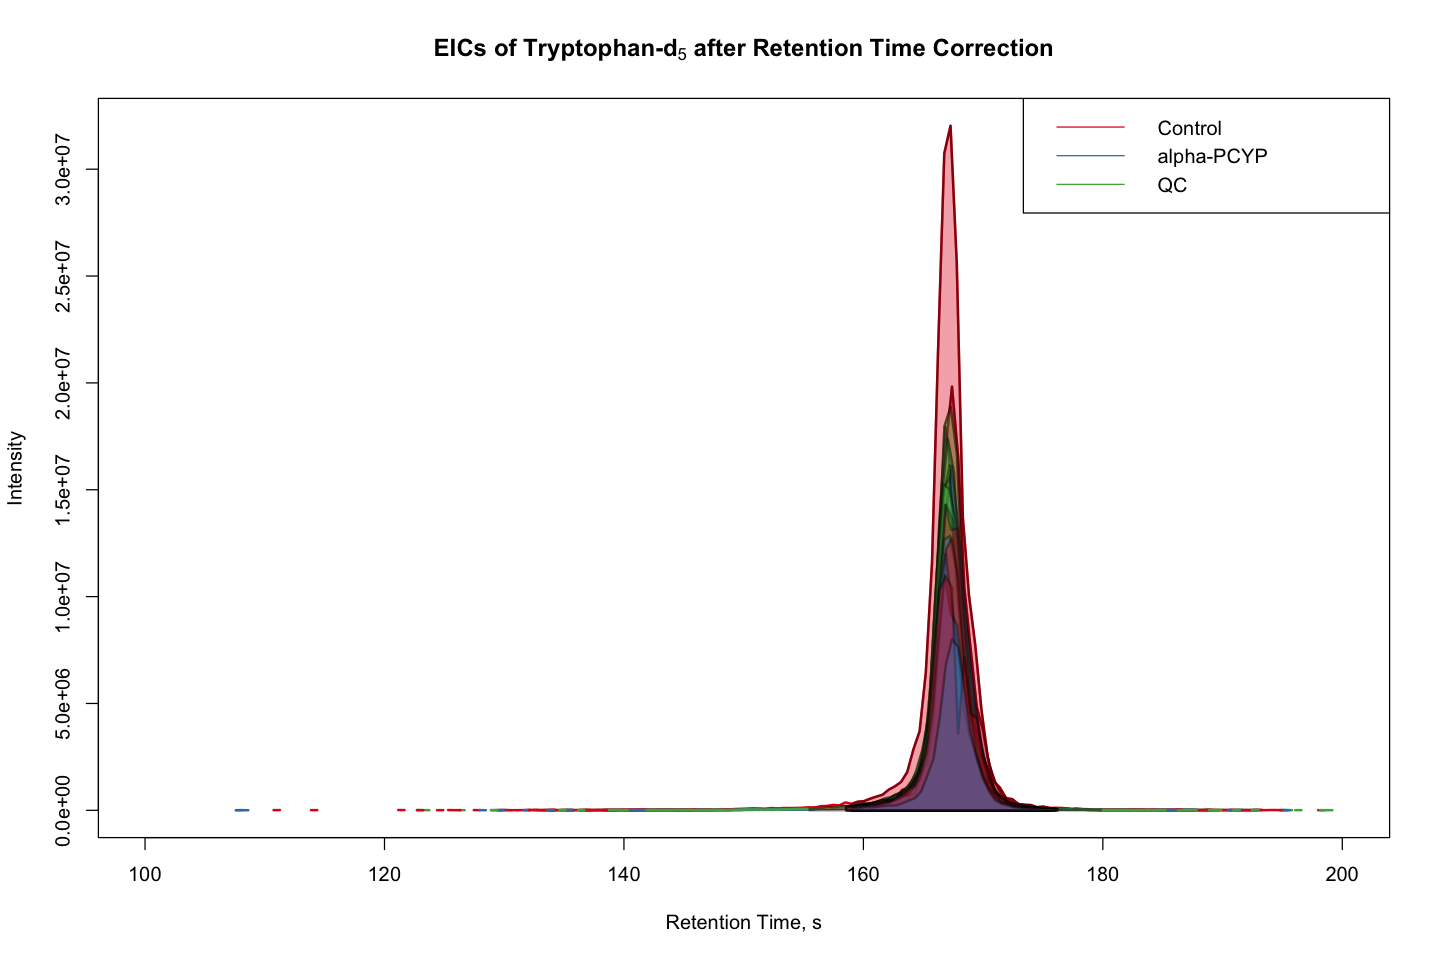

In [19]:
## Plot tryptophan-d5 after retention time correction (m/z 210.1291, 168 s)
trpd5.corr <- chromatogram(set, mz = c(210.1281, 210.1301), rt = c(100, 200))

plot(trpd5.corr, col = group.colours[trpd5.raw$sample_group], lwd = 2,
     peakBg = sample.colours[chromPeaks(trpd5.corr)[, "sample"]],
     peakPch = 16, main = bquote(bold("EICs of Tryptophan-d"[5]*" after Retention Time Correction")),
     xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

In [23]:
## Plot Crea after after retention time correction (m/z 114.0665, 287 s)
crea.corr <- chromatogram(set, mz = c(114.0645, 114.0685), rt = c(100, 500))

plot(crea.corr, col = group.colours[crea.raw$sample_group], lwd = 2,
     peakBg = sample.colours[chromPeaks(crea.corr)[, "sample"]],
     peakPch = 16, main = bquote(bold("EICs of Crea after Retention Time Correction")),
     xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

ERROR: Error in .plotChromatogramList(x[i, , drop = TRUE], col = col, lty = lty, : Objekt 'crea.raw' nicht gefunden


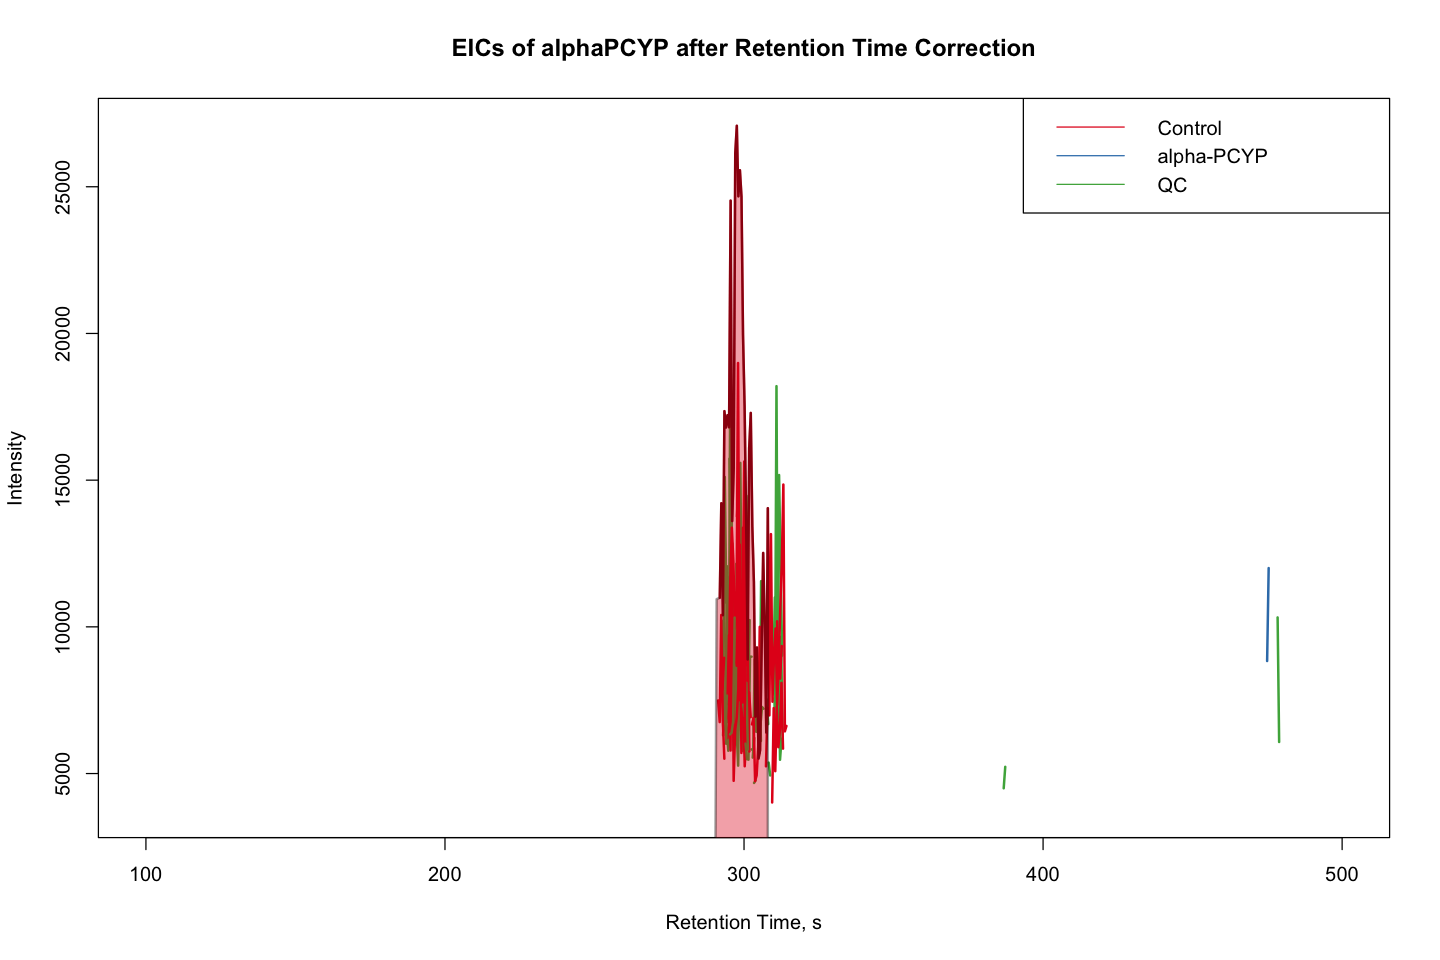

In [20]:
## Plot alpha-PCYP after retention time correction (m/z 272.2008, 314 s)
alphaPCYP.corr <- chromatogram(set, mz = c(272.2000, 272.2015), rt = c(100, 500))

plot(alphaPCYP.corr, col = group.colours[alphaPCYP.raw$sample_group], lwd = 2,
     peakBg = sample.colours[chromPeaks(alphaPCYP.corr)[, "sample"]],
     peakPch = 16, main = bquote(bold("EICs of alphaPCYP"*" after Retention Time Correction")),
     xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

# Peak Grouping

In [21]:
suppressMessages(
    
    set <- groupChromPeaks(set, param = pdp)
    
)

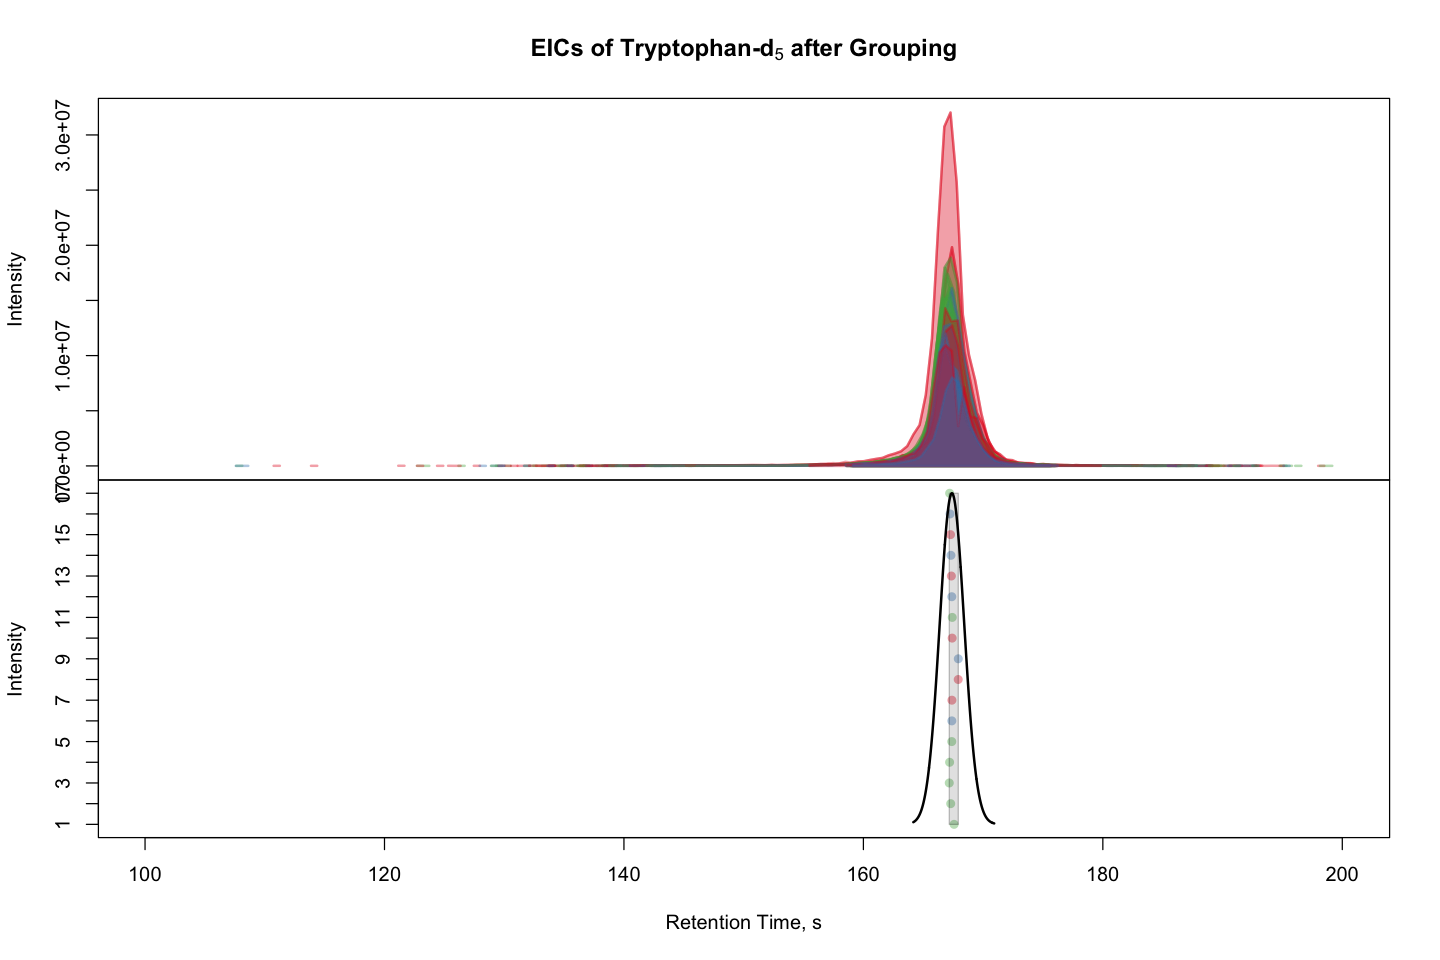

In [22]:
## Plot trp-d5 after peak grouping
trpd5.grouped <- chromatogram(set, mz = c(210.1281, 210.1301), rt = c(100, 200))

## Define the parameters for the peak density method
plotChromPeakDensity(trpd5.grouped, col = sample.colours, param = pdp, lwd = 2,
                     peakBg = sample.colours[chromPeaks(trpd5.grouped)[, "sample"]],
                     peakCol = sample.colours[chromPeaks(trpd5.grouped)[, "sample"]],
                     peakPch = 16, main = bquote(bold("EICs of Tryptophan-d"[5]*" after Grouping")),
                     xlab = "Retention Time, s", ylab = "Intensity")

In [23]:
## Plot Crea after peak grouping
crea.grouped <- chromatogram(set, mz = c(114.0645, 114.0685), rt = c(300, 400))

## Define the parameters for the peak density method
plotChromPeakDensity(crea.grouped, col = sample.colours, param = pdp, lwd = 2,
                     peakBg = sample.colours[chromPeaks(crea.grouped)[, "sample"]],
                     peakCol = sample.colours[chromPeaks(crea.grouped)[, "sample"]],
                     peakPch = 16, main = bquote(bold("EICs of Crea after Grouping")),
                     xlab = "Retention Time, s", ylab = "Intensity")

ERROR: Error: No chromatographic peaks present. Please run 'findChromPeaks' first.


# Peak Filling

In [24]:
suppressMessages(    
     
    set <- fillChromPeaks(set, param = ChromPeakAreaParam())
    
)

ERROR: Error in h(simpleError(msg, call)): Fehler bei der Auswertung des Argumentes 'param' bei der Methodenauswahl für Funktion 'fillChromPeaks': konnte Funktion "ChromPeakAreaParam" nicht finden


# Postprocessing


# Annotation of Adducts and Isotopes

In [25]:
## Summarise experiment
results <- quantify(set, value = "into")
class(results)

[1] "SummarizedExperiment"
attr(,"package")
[1] "SummarizedExperiment"

In [26]:
rowData(results) %>%
head()

DataFrame with 6 rows and 12 columns
           mzmed     mzmin     mzmax     rtmed     rtmin     rtmax    npeaks
       <numeric> <numeric> <numeric> <numeric> <numeric> <numeric> <numeric>
FT0001   59.0501   59.0501   59.0502  275.8134  274.8245  277.1469        17
FT0002   59.0501   59.0501   59.0502  289.8055  289.5360  290.3114        14
FT0003   62.0408   62.0376   62.0440   64.5559   63.6296   67.0424        34
FT0004   64.0168   64.0167   64.0168  594.2972  593.7455  594.6560        10
FT0005   65.0201   65.0200   65.0201  594.1373  593.6362  594.7605        15
FT0006   71.0496   71.0495   71.0497  468.2556  467.9498  468.6934        11
       alpha.PCYP   Control        QC               peakidx  ms_level
        <numeric> <numeric> <numeric>                <list> <integer>
FT0001          5         5         7     788,3322,5780,...         1
FT0002          4         5         5  5779, 8038,10190,...         1
FT0003          5         5         7     569,1076,3120,...        

In [27]:
## Add classic feature names
rowData(results)$label <- paste0("M",round(rowData(results)$mzmed,0),
                           "T", round(rowData(results)$rtmed,0))
rowData(results) %>%
head()

DataFrame with 6 rows and 13 columns
           mzmed     mzmin     mzmax     rtmed     rtmin     rtmax    npeaks
       <numeric> <numeric> <numeric> <numeric> <numeric> <numeric> <numeric>
FT0001   59.0501   59.0501   59.0502  275.8134  274.8245  277.1469        17
FT0002   59.0501   59.0501   59.0502  289.8055  289.5360  290.3114        14
FT0003   62.0408   62.0376   62.0440   64.5559   63.6296   67.0424        34
FT0004   64.0168   64.0167   64.0168  594.2972  593.7455  594.6560        10
FT0005   65.0201   65.0200   65.0201  594.1373  593.6362  594.7605        15
FT0006   71.0496   71.0495   71.0497  468.2556  467.9498  468.6934        11
       alpha.PCYP   Control        QC               peakidx  ms_level
        <numeric> <numeric> <numeric>                <list> <integer>
FT0001          5         5         7     788,3322,5780,...         1
FT0002          4         5         5  5779, 8038,10190,...         1
FT0003          5         5         7     569,1076,3120,...        

In [28]:
assay(results) %>% 
head()

pQC_1.mzXML pQC_2.mzXML pQC_3.mzXML pQC_4.mzXML pQC_5.mzXML
FT0001  1346502.6   1376316.7  1209348.2    1167386.2  1199855.9  
FT0002         NA          NA  1124038.8    1042861.3  1075312.7  
FT0003  2891053.9   4269114.8  5208146.0    5019525.0  3135359.7  
FT0004 45419661.6  43773191.0         NA   43875047.4         NA  
FT0005   847131.6    902803.9   835686.5     768239.8   758192.5  
FT0006         NA          NA   243663.8           NA   215445.2  
       24h_Urine_Rat_Control_5.mzXML 24h_Urine_Rat_PCYP_4.mzXML
FT0001  1231767.4                    1260401.3                 
FT0002   980712.2                     990640.3                 
FT0003  3666026.5                    3754415.4                 
FT0004 37525838.1                           NA                 
FT0005   673461.5                           NA                 
FT0006   221607.7                     182482.8                 
       24h_Urine_Rat_PCYP_1.mzXML 24h_Urine_Rat_Control_3.mzXML
FT0001  1252324.1                  1211011.5                   
FT0002   969072.3                  1010144.2                   
FT0003  3099243.8                  3170462.4                   
FT0004 36693996.5                 34089689.7                   
FT0005   677689.0                   690378.7                   
FT0006         NA                         NA                   
       24h_Urine_Rat_PCYP_2.mzXML pQC_6.mzXML 24h_Urine_Rat_Control_2.mzXML
FT0001  1225894.4                  1153746.5  1253257.1                    
FT0002  1057861.1                  1115296.2  1020735.3                    
FT0003  4338920.1                  4056218.5  4176962.8                    
FT0004 35358824.2                 41493092.1         NA                    
FT0005   635818.6                   822269.6   742801.2                    
FT0006   185346.1                   189715.8   173854.6                    
       24h_Urine_Rat_PCYP_5.mzXML 24h_Urine_Rat_Control_4.mzXML
FT0001  1212904.5                 1208104.2                    
FT0002  1016320.4                  988303.0                    
FT0003  4370348.1                 2438919.4                    
FT0004 37567232.7                        NA                    
FT0005         NA                  778690.1                    
FT0006   126501.2                  223505.2                    
       24h_Urine_Rat_PCYP_3.mzXML 24h_Urine_Rat_Control_1.mzXML pQC_7.mzXML
FT0001 1168872.5                  1319667.3                      1266665.9 
FT0002 1072123.5                         NA                      1054593.7 
FT0003 5029957.0                  2056816.5                      2997350.7 
FT0004        NA                         NA                     40627577.9 
FT0005  809581.0                   644198.8                       673379.6 
FT0006  132649.6                         NA                       210273.3

In [29]:
## Perform annotation using CAMERA
suppressMessages({
    
    camera <- set %>%
              as("xcmsSet") %>%
              CAMERA::annotate(polarity  = "positive") %>%
              getPeaklist() %>%
              dplyr::select(isotopes, adduct, pcgroup)
    
})

## Save annotation results in SummarizedExperiment class
rowData(results)$isotopes <- camera$isotopes
rowData(results)$adduct <- camera$adduct
rowData(results)$pcgroup <- camera$pcgroup

Start grouping after retention time.
Created 139 pseudospectra.
Generating peak matrix!
Run isotope peak annotation
 % finished: 10  20  30  40  50  60  70  80  90  100  
Found isotopes: 554 
Start grouping after correlation.
Generating EIC's .. 

Calculating peak correlations in 139 Groups... 
 % finished: 10  20  30  40  50  60  70  80  90  100  

Calculating graph cross linking in 139 Groups... 
 % finished: 10  20  30  40  50  60  70  80  90  100  
New number of ps-groups:  1237 
xsAnnotate has now 1237 groups, instead of 139 
Generating peak matrix for peak annotation!

Calculating possible adducts in 1237 Groups... 
 % finished: 10  20  30  40  50  60  70  80  90  100  


# Scaling

Before log10 transformation, every NA in the data matrix is replaced by the surrogate LOD according to Wehrens et al. at DOI: 10.1007/s11306-016-1015-8. The surrogate LOD is the lowest area that was measured during the analysis.

In [30]:
assays(results)

List of length 1
names(1): raw

In [31]:
# Replacing 0s with surrogate LOD
lod <- assay(results, "raw")[is.na(assay(results, "raw")) == FALSE] %>%
       min()
assay(results, "raw")[is.na(assay(results, "raw"))] <- lod

# Create assay results after log10 transformation
assay(results, "scaled") <- assay(results, "raw") %>%
                            log10()

In [32]:
assays(results)

List of length 2
names(2): raw scaled

In [33]:
results %>%
assay("scaled") %>%
head()

pQC_1.mzXML pQC_2.mzXML pQC_3.mzXML pQC_4.mzXML pQC_5.mzXML
FT0001 6.129207    6.138718    6.082551    6.067215    6.079129   
FT0002 4.339488    4.339488    6.050781    6.018227    6.031535   
FT0003 6.461056    6.630338    6.716683    6.700663    6.496287   
FT0004 7.657244    7.641208    4.339488    7.642218    4.339488   
FT0005 5.927951    5.955593    5.922043    5.885497    5.879779   
FT0006 4.339488    4.339488    5.386791    4.339488    5.333337   
       24h_Urine_Rat_Control_5.mzXML 24h_Urine_Rat_PCYP_4.mzXML
FT0001 6.090529                      6.100509                  
FT0002 5.991542                      5.995916                  
FT0003 6.564196                      6.574542                  
FT0004 7.574330                      4.339488                  
FT0005 5.828313                      4.339488                  
FT0006 5.345585                      5.261222                  
       24h_Urine_Rat_PCYP_1.mzXML 24h_Urine_Rat_Control_3.mzXML
FT0001 6.097717                   6.083148                     
FT0002 5.986356                   6.004383                     
FT0003 6.491256                   6.501123                     
FT0004 7.564595                   7.532623                     
FT0005 5.831030                   5.839087                     
FT0006 4.339488                   4.339488                     
       24h_Urine_Rat_PCYP_2.mzXML pQC_6.mzXML 24h_Urine_Rat_Control_2.mzXML
FT0001 6.088453                   6.062110    6.098040                     
FT0002 6.024429                   6.047390    6.008913                     
FT0003 6.637382                   6.608121    6.620861                     
FT0004 7.548498                   7.617976    4.339488                     
FT0005 5.803333                   5.915014    5.870873                     
FT0006 5.267983                   5.278104    5.240186                     
       24h_Urine_Rat_PCYP_5.mzXML 24h_Urine_Rat_Control_4.mzXML
FT0001 6.083827                   6.082104                     
FT0002 6.007031                   5.994890                     
FT0003 6.640516                   6.387197                     
FT0004 7.574809                   4.339488                     
FT0005 4.339488                   5.891365                     
FT0006 5.102095                   5.349288                     
       24h_Urine_Rat_PCYP_3.mzXML 24h_Urine_Rat_Control_1.mzXML pQC_7.mzXML
FT0001 6.067767                   6.120464                      6.102662   
FT0002 6.030245                   4.339488                      6.023085   
FT0003 6.701564                   6.313196                      6.476738   
FT0004 4.339488                   4.339488                      7.608821   
FT0005 5.908260                   5.809020                      5.828260   
FT0006 5.122706                   4.339488                      5.322784

# Normalisation

In [50]:
## Define function to calculate ppm deviation
ppm <- function(x,y) {

    return(10^6 * (x - y) / y)

}

## Define function to identify row of compound
identify <- function(data, mz, rt, ppmlim, rtlim) {

    delta.mz <- abs(mapply(ppm, x = data$mzmed, y = mz))
    delta.rt <- abs(data$rtmed - rt)
    return(which(delta.mz < ppmlim & delta.rt < rtlim))
    
}

In [51]:
## Identify rownumber of internal standard tryptophan-d5
crea <- results %>%
         rowData() %>%
         as.data.frame() %>%
         identify(mz = 114.0666, rt = 335, 5, 10)

In [53]:
## Normalise data to internal standard
norm.is <- function(x, is){x/x[is]}
assay(results, "norm") <- apply(assay(results, "scaled"),2, norm.is, is = crea)

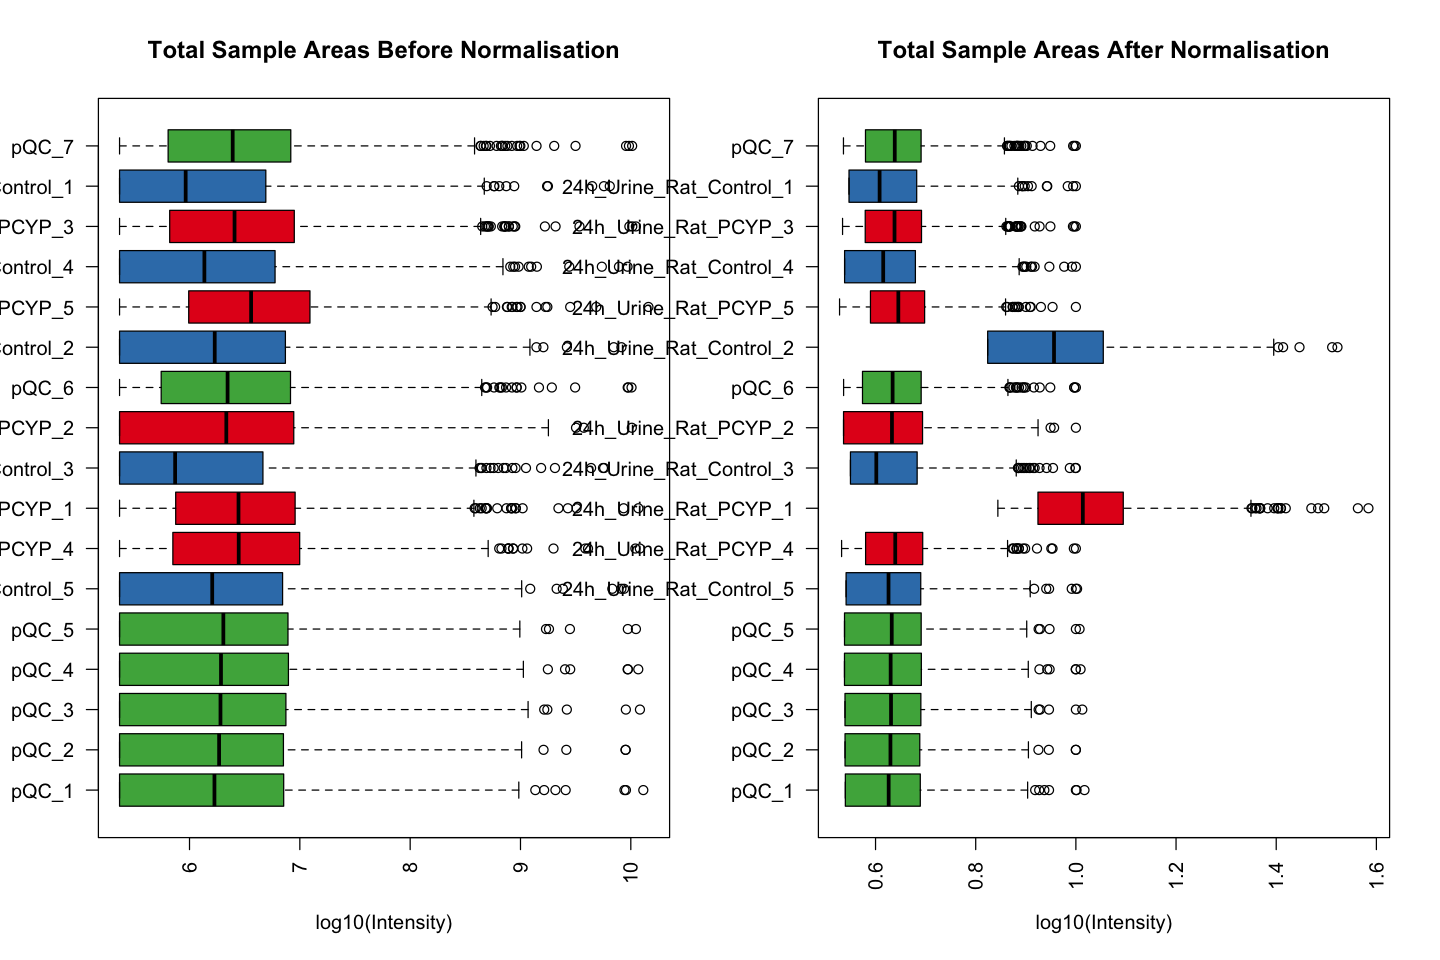

In [54]:
## Compare normalised and unnormalised data
par(mfrow = c(1,2))

results %>%
assay("scaled") %>%
boxplot(names = results$sample_name, horizontal = TRUE,
        col = group.colours[results$sample_group], xlab = "log10(Intensity)", 
        main = "Total Sample Areas Before Normalisation", las = 2)

results %>%
assay("norm") %>%
boxplot(names = results$sample_name, horizontal = TRUE,
        col = group.colours[results$sample_group], xlab = "log10(Intensity)", 
        main = "Total Sample Areas After Normalisation", las = 2)

# Batch correction

In [34]:
## Define function to perform batch correction
batchCorrection <-function(area, order, group, output = c("df", "corr")) {
        
    df <- data.frame(order = order, area = area)
    model <- lm(area ~ order, data = df[group == "QC",])
    df$pred <- predict(model, newdata = df)
    df$corr <- df$corr <- df$area - df$pred + mean (df$area)
    return(switch(output, df = df, corr = df$corr))
    
}

In [35]:
## Filter features by detectability in QC samples
#results.filtered <- results[rowData(results)$QC == 9,]

In [36]:
## Perform batch correction
assay(results, "batchcorr",
      withDimnames = FALSE) <- apply(assay(results, "scaled"), 
                                     1, batchCorrection, 
                                     order = set$sample_order, 
                                     group = set$sample_group, 
                                     output = "corr") %>%
                                     t()

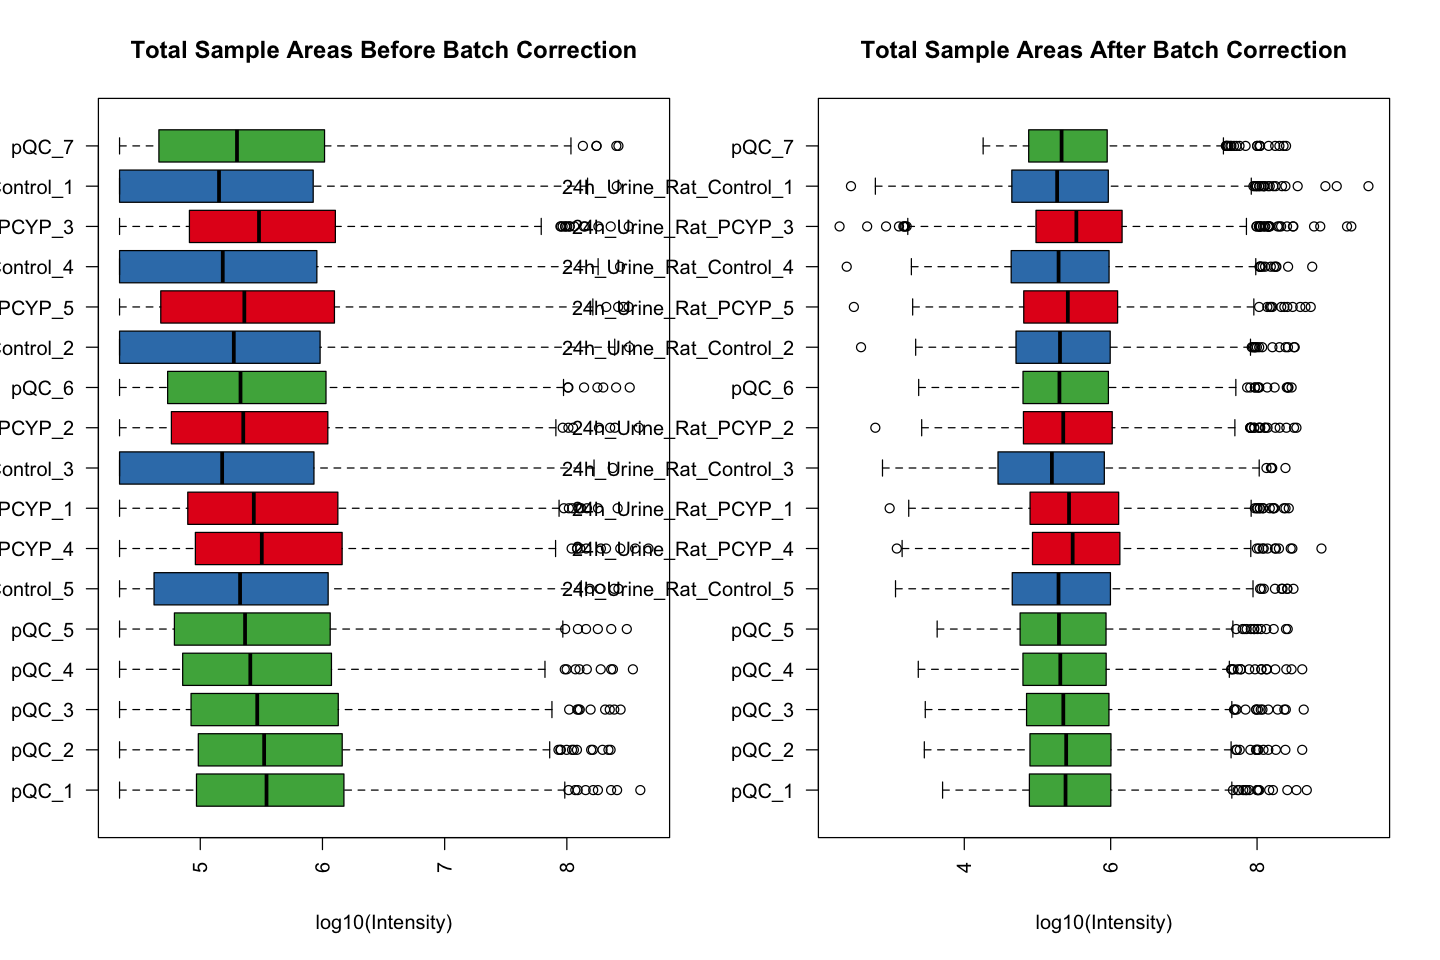

In [37]:
## Compare batch-corrected and uncorrected total sample areas
par(mfrow = c(1,2))

results %>%
assay("scaled") %>%
boxplot(names = results$sample_name, horizontal = TRUE,
        col = group.colours[results$sample_group], xlab = "log10(Intensity)", 
        main = "Total Sample Areas Before Batch Correction", las = 2)

results %>%
assay("batchcorr") %>%
boxplot(names = results$sample_name, horizontal = TRUE,
        col = group.colours[results$sample_group], xlab = "log10(Intensity)", 
        main = "Total Sample Areas After Batch Correction", las = 2)

In [38]:
## Compare batch-corrected and uncorrected areas of compounds
df <- batchCorrection(assay(results, "scaled")[51,], 
                      set$sample_order, set$sample_group, "df")

## Perform regression using corrected values
lm <- lm(area ~ order, data = df[results$sample_group == "QC",])
lm.new <- lm(corr ~ order, data = df[results$sample_group == "QC",])

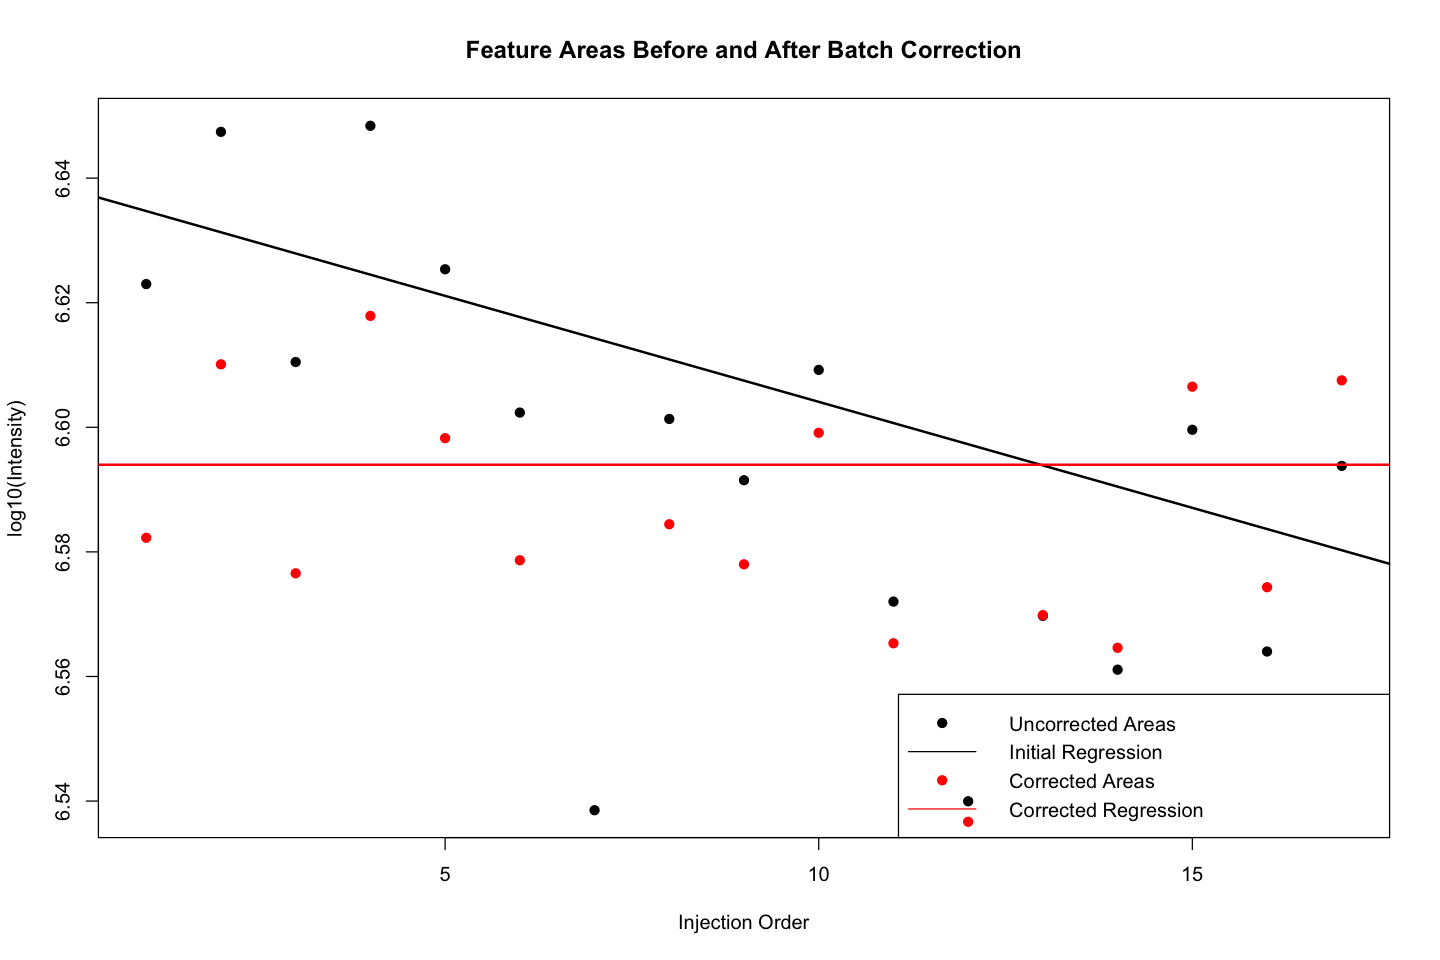

In [39]:
## Plot uncorrected and corrected models and data points
plot(df$order, df$area, col = "black", pch = 19,
     xlab = "Injection Order", ylab = "log10(Intensity)", 
     main = "Feature Areas Before and After Batch Correction")
abline(lm, lwd = 2, col = "black")
points(df$order, df$corr, col = "red", pch = 19)
abline(lm.new, lwd = 2, col = "red")
legend("bottomright", lty = c(NA,1,NA,1), pch=c(19,NA,19,NA),
       legend = c("Uncorrected Areas", "Initial Regression", 
                  "Corrected Areas", "Corrected Regression"), 
       col = c("black", "black", "red", "red"))